# Influenza Competition model
This is a test model for population change in a pool of virus with 1 segmented virus and multi-segmented virus. Virus accumulates deleterious mutations that reduces selection coefficient, and the negative impact of the mutant allele is multiplicative.  

In [1]:
import numpy as np

class Virus():
    """
    This class produces objects which are single agents of a influenza virus.
    seg_n = number of segments
    k = number of deleterious mutation
    s = fitness decrease from deleterious mutation
    L = sequence length for a virus
    cost = cost of having multisegments
    w = fitness
    progeny_n = number of progenies a virus agent will have during reproduction. Default is 0.
    seq = allele sequence vector
    one_index = index of allele that is 1 (mutant)
    """
    def __init__(self,one_index,k,seg_n):
        self.seg_n = seg_n
        self.k = k
        self.s = s
        self.L = L
        self.cost = cost
        self.progeny_n = 0
        if self.seg_n == 1:
            self.w = (1 - self.s)**self.k
        else:
            self.w = (1 - self.s)**self.k - self.cost
        self.seq = np.repeat(0,self.L)
        for i in one_index:
            self.seq[i] = 1
    
    def mutate(self,mu):
        """
        Mutation in sequence before reproduction
        mu = mutation rate
        """
        self.mutation_num = np.random.binomial(self.L, mu) # number of mutation
        mut_seq_index = np.random.randint(self.L, size = self.mutation_num) # pick which allele goes thru mutation
        for i in mut_seq_index:
            if self.seq[i] == 1: # back mutation allowed.
                self.seq[i] = 0
                self.k -= 1
            else:
                self.seq[i] = 1
                self.k += 1

<b>Reproduction process</b>:
Inputs virus population (1 and 2 segmented) and outputs the virus population of next generation.
The 1 segmented virus goes through reproduction without reassortment as done in 1 segment influenza model.
number of offspring per virus agent gets decided by the poisson sampling with a parameter that reflects selection coefficient and carrying capacity.
The 2 segmented virus goes through reproduction with reassortment.
Number of offspring per virus gets decided similarly, but 2 virus produces 1 virus. The last remaining virus particle goes through reproduction in a same way as 1 segmented virus.



In [2]:
def reproduce(viruses1, viruses2):
    """
    input
        viruses1 = array of 1segmented virus agents.
        viruses2 = array of multi-segmented virus agents.
    output
        next_gen1 = array of 1segemented virus of next generation.
        next_gen2 = array of multi-segemented virus of next generation.
    """
    next_gen1 = []
    next_gen2 = []
    
    for i in range(len(viruses1)): # reproduction of 1segs
        progeny_n = np.random.poisson(viruses1[i].w*(2/(1+N/K))) # number of progeny for that virus
        for j in range(progeny_n):
            one_index = np.where(viruses1[i].seq == 1)[0]
            next_gen1.append(Virus(one_index, viruses1[i].k, 1))
            
    remaining = [] # virus parents with remaining progenies to reproduce (for multi-segs)
    for i in range(len(viruses2)): # reproduction of multi-segs
        viruses2[i].progeny_n = np.random.poisson(viruses2[i].w*(2/(1+N/K)))
        if viruses2[i].progeny_n > 0:
            remaining.append(i)
    while len(remaining) >= 2: # while there's at least 2 remaining viruses to reproduce together
        samp = sorted(np.random.choice(remaining, 2, replace=False)) # pick 2 from the remaining
        offspring1, offspring2 = reassort(viruses2[samp[0]], viruses2[samp[1]])
        next_gen2.append(offspring1)
        next_gen2.append(offspring2)
        viruses2[samp[0]].progeny_n -= 1
        viruses2[samp[1]].progeny_n -= 1
        if viruses2[samp[0]].progeny_n == 0: # remove index from remaining if progeny_n is 0.
            del remaining[np.where(np.array(remaining)==samp[0])[0][0]]
        if viruses2[samp[1]].progeny_n == 0:
            del remaining[np.where(np.array(remaining)==samp[1])[0][0]]
    # when there's only 1 index reamining, go through regular reproduction (no reassortment)
    for i in remaining:
        for j in range(viruses2[i].progeny_n):
            one_index = np.where(viruses2[i].seq == 1)[0]
            next_gen2.append(Virus(one_index, viruses2[i].k, 2))
    return next_gen1, next_gen2

<b> Reassortment process </b>:
In reassortment, two 2 segmented viruses mix
there segments to produce 2 offspring, or they just clone themselves. 
There's a r percent chance that they mix and other 50 that they don't.
When they mix one offspring gets first segment from v1 and the other
gets the first segment from v2. First segment of virus is 0:L/2 and
the second segment of virus is L/2:L.

Input:
    2 parent virus objects
Output:
    2 child virus objects

In [3]:
def reassort(v1, v2):
    prob = np.random.uniform(0,1)
    if prob < r: # reassortment
        # v1 gives first segment
        one_index1 = np.where(v1.seq[0:int(L/2)] == 1)[0] # index of mutant allele of 1st seg
        one_index2 = np.where(v2.seq[int(L/2)::] == 1)[0] # index of mutant allele of 2nd seg
        one_index2 = one_index2 + int(L/2)
        one_index = list(one_index1) + list(one_index2) # mix the segment
        k = len(one_index)
        offspring1 = Virus(one_index, k, v1.seg_n)
        # v2 gives first segment
        one_index1 = np.where(v2.seq[0:int(L/2)] == 1)[0] # index of mutant allele of 1st seg
        one_index2 = np.where(v1.seq[int(L/2)::] == 1)[0] # index of mutant allele of 2nd seg
        one_index2 = one_index2 + int(L/2)
        one_index = list(one_index1) + list(one_index2) # mix the segment
        k = len(one_index)
        offspring2 = Virus(one_index, k, v1.seg_n)
        return offspring1, offspring2
    else: # no reassortment
        one_index = np.where(v1.seq == 1)[0]
        k = len(one_index)
        offspring1 = Virus(one_index, k, v1.seg_n)
        
        one_index = np.where(v2.seq == 1)[0]
        k = len(one_index)
        offspring2 = Virus(one_index, k, v1.seg_n)
        
        return offspring1, offspring2

### Parameters
* L = sequence length for a virus
* N = Population size (N0 = initial population)
* K = Carrying capacity
* s = fitness decrease from deleterious mutation
* mu = mutation rate
* gen_num = generation amount 
* r = reassortment rate

In [13]:
# change parameters if needed before running it.
L = 300
s = 0.05
N0 = 1000
K = 1000
mu = 0.0005
gen_num = 500
cost = 0.00
r = 0.5
N = N0

Now go through each generation and write down the population to csv. In each generation the viruses mutate and then reproduce.

In [18]:
import datetime
import timeit
from progress.bar import Bar

bar = Bar('Processing', max=100) # progress bar start
# Initialize the virus population. Each subpopulation gets half the population.
N = N0
viruses1 = []
viruses2 = []
for i in range(int(N/2)):
    viruses2.append(Virus([],0,2))
for i in range(int(N/2)):
    viruses1.append(Virus([],0,1))

start = timeit.default_timer()

# write out data with file name indicating time it started collecting
now = datetime.datetime.now()
file_name = './data/Influenza_comp_%s.csv'%(now.strftime("%Y.%m.%d_%H:%M"))
fh = open(file_name,'w')

fh.write('gen,pop1,pop2,k1,k2\n')
fh.write('%d,%d,%d,%.2f,%.2f\n'%(1,len(viruses1),len(viruses2),0.00,0.00))

# run the simulation
for gen in range(gen_num):
    for i in range(len(viruses1)):
        viruses1[i].mutate(mu)
    for j in range(len(viruses2)):
        viruses2[j].mutate(mu)
    viruses1, viruses2 = reproduce(viruses1,viruses2)
    N = len(viruses1) + len(viruses2)
    ks = [] # k of each virus of a subpop in each generation
    if len(viruses1)>0: # get the mean k of subpop 1
        for i in range(len(viruses1)):
            ks.append(viruses1[i].k)
        k_means1 = np.mean(np.array(ks))
    else:
        k_means1 = -1 # if pop=0, kmean=-1
    ks = []
    if len(viruses2)>0: # get the mena k of subpop 1
        for j in range(len(viruses2)):
            ks.append(viruses2[j].k)
        k_means2 = np.mean(np.array(ks))
    else:
        k_means2 = -1
        
    fh.write('%d,%d,%d,%.2f,%.2f\n'%(gen+1,len(viruses1),len(viruses2),
                                 k_means1, k_means2))
    bar.next()
    
fh.close()
stop = timeit.default_timer()
print('\nthe simulation ran for %.2f min'%((stop - start)/60))
bar.finish()


the simulation ran for 0.32 min


Plot the results

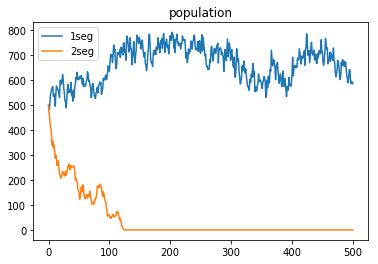

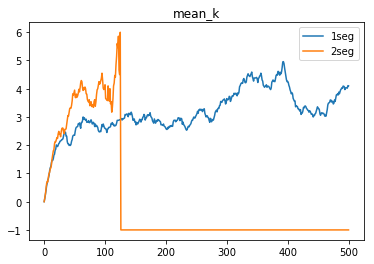

In [19]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

# file_name = 'Influenza_comp_' + '' + '.csv'
data = pandas.read_csv(file_name)
plt.plot(data['pop1'], label='1seg')
plt.plot(data['pop2'], label='2seg')
plt.title('population')
plt.legend()
plt.show()

plt.plot(data['k1'], label='1seg')
plt.plot(data['k2'], label='2seg')
plt.legend()
plt.title('mean_k')
plt.show()